In [4]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import cv2

# CLASSIFICATION

In [13]:
class VideosDataset(Sequence):
    def __init__(self, image_dir, annotation_dir, label_encoder, transform=None, batch_size=32):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.label_encoder = label_encoder
        self.transform = transform
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.image_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        labels = []

        for img_name in batch_files:
            img_path = os.path.join(self.image_dir, img_name)

            try:
                image = Image.open(img_path).convert("RGB")
            except Exception as e:
                # print(f"Error opening image {img_name}: {e}")
                continue

            annotation_name = img_name.replace('.jpg', '.csv')
            annotation_path = os.path.join(self.annotation_dir, annotation_name)

            try:
                annotation = pd.read_csv(annotation_path, header=None)
            except Exception as e:
                # print(f"Error reading {annotation_name}: {e}")
                annotation = pd.DataFrame()

            if annotation.empty:
                label = self.label_encoder.transform(['empty'])[0]
                if self.transform:
                    image = self.transform(image)
                images.append(np.array(image))
                labels.append(label)
                continue

            for _, line in annotation.iterrows():
                try:
                    label_str = line[4]
                    if label_str != 'empty':
                        x1 = int(line[0])
                        y1 = int(line[1])
                        x2 = int(line[2])
                        y2 = int(line[3])
                        roi = image.crop((x1, y1, x2, y2))
                    else:
                        roi = image
                except Exception as e:
                    # print(f"Error processing annotation {annotation_name}: {e}")
                    continue

                if self.transform:
                    roi = self.transform(roi)

                label = self.label_encoder.transform([label_str])[0]
                images.append(np.array(roi))
                labels.append(label)

        images = np.array(images)
        labels = np.array(labels)
        return images, labels

In [14]:
def transform(image):
    image = image.resize((128, 128))
    image = np.array(image) / 255.0
    return image

In [5]:
image_dir = 'train/images2'
annotation_dir = 'train/labels2'

annotations = ['ff']
for filename in os.listdir(annotation_dir):
    if filename.endswith('.csv'):
        filepath = os.path.join(annotation_dir, filename)
        try:
            df = pd.read_csv(filepath, header=None)
            if not df.empty:
                annotations.extend(df.iloc[:, 4].values)
        except Exception as e:
            pass

In [6]:
label_encoder_class = LabelEncoder()
label_encoder_class.fit(annotations)

LabelEncoder()

In [17]:
train_dataset = VideosDataset(image_dir='train/images2',
                              annotation_dir='train/labels2',
                              label_encoder=label_encoder_class,
                              transform=transform,
                              batch_size=32)

val_dataset = VideosDataset(image_dir='val/images',
                            annotation_dir='val/labels',
                            label_encoder=label_encoder_class,
                            transform=transform,
                            batch_size=32)

In [18]:
num_classes = len(label_encoder_class.classes_)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
num_epochs = 10
history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

Epoch 1/10


2024-06-22 23:52:52.200046: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


34/34 [==============================] - 18s 508ms/step - loss: 1.8544 - accuracy: 0.3810 - val_loss: 0.9396 - val_accuracy: 0.7721
Epoch 2/10
34/34 [==============================] - 14s 419ms/step - loss: 0.7121 - accuracy: 0.7859 - val_loss: 0.4539 - val_accuracy: 0.8382
Epoch 3/10
34/34 [==============================] - 14s 420ms/step - loss: 0.4542 - accuracy: 0.8559 - val_loss: 0.3968 - val_accuracy: 0.9191
Epoch 4/10
34/34 [==============================] - 14s 421ms/step - loss: 0.3572 - accuracy: 0.8882 - val_loss: 0.3769 - val_accuracy: 0.9485
Epoch 5/10
34/34 [==============================] - 20s 571ms/step - loss: 0.2885 - accuracy: 0.9055 - val_loss: 0.3717 - val_accuracy: 0.9412
Epoch 6/10
34/34 [==============================] - 17s 484ms/step - loss: 0.2370 - accuracy: 0.9228 - val_loss: 0.3098 - val_accuracy: 0.9485
Epoch 7/10
34/34 [==============================] - 15s 443ms/step - loss: 0.2181 - accuracy: 0.9246 - val_loss: 0.2995 - val_accuracy: 0.9559
Epoch 8/10

In [9]:
model.save('model.h5')

In [19]:
model = tf.keras.models.load_model('model.h5')

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

NameError: name 'history' is not defined

In [20]:
# show 10 random images from the validation set
val_images, val_labels = val_dataset.__getitem__(0)
val_predictions = model.predict(val_images)
val_predictions = np.argmax(val_predictions, axis=1)

2024-06-23 10:57:29.275048: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 [==============================] - 0s 32ms/step


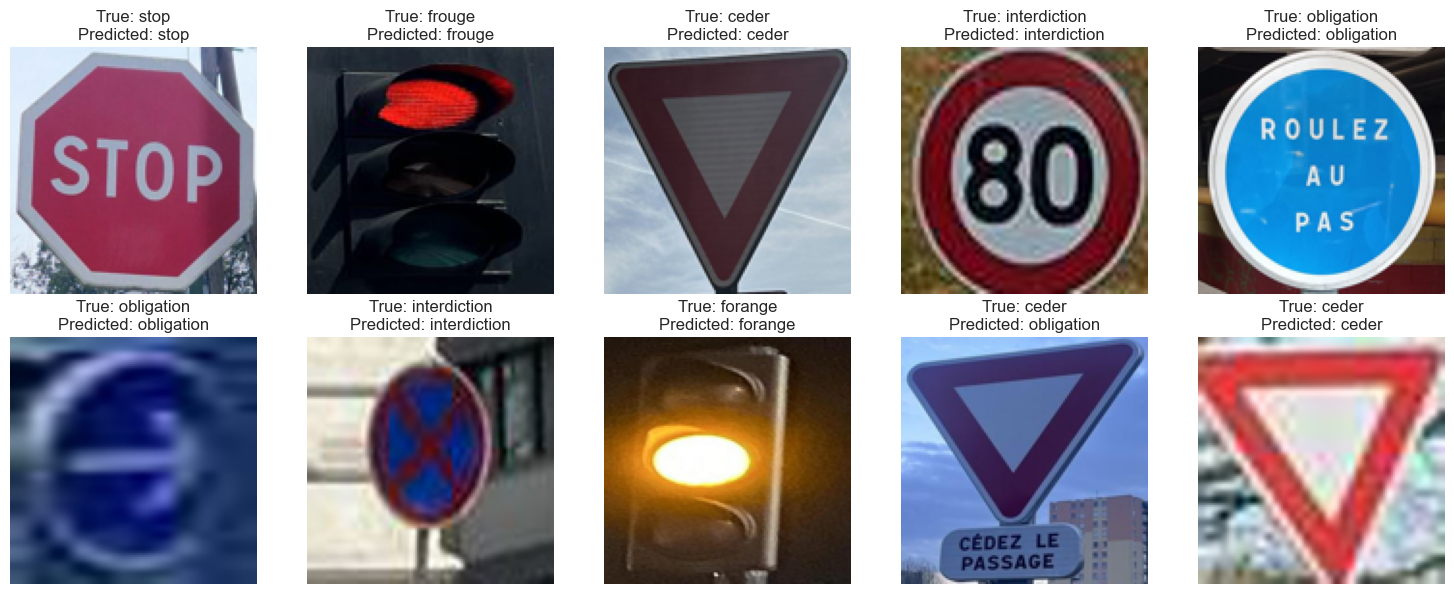

In [21]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(val_images))
    ax.imshow(val_images[idx])
    ax.set_title(f"True: {label_encoder_class.classes_[val_labels[idx]]}\nPredicted: {label_encoder_class.classes_[val_predictions[idx]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# DETECTION

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from sklearn.preprocessing import LabelEncoder
import random

def get_non_overlapping_bbox(image_size, bboxes, min_size=32, max_size=128):
    attempts = 0
    while attempts < 100:
        x1 = random.randint(0, image_size[0] - min_size)
        y1 = random.randint(0, image_size[1] - min_size)
        x2 = random.randint(x1 + min_size, min(image_size[0], x1 + max_size))
        y2 = random.randint(y1 + min_size, min(image_size[1], y1 + max_size))

        overlap = False
        for bbox in bboxes:
            if not (x2 < bbox[0] or x1 > bbox[2] or y2 < bbox[1] or y1 > bbox[3]):
                overlap = True
                break
        if not overlap:
            return (x1, y1, x2, y2)
        attempts += 1
    return None

In [36]:
def augment_dataset_with_empty(image_dir, annotation_dir, output_annotation_dir, num_empty_per_image=5):
    if not os.path.exists(output_annotation_dir):
        os.makedirs(output_annotation_dir)

    for img_name in os.listdir(image_dir):
        print("Treating image", img_name)
        if not img_name.endswith('.jpg'):
            continue

        img_path = os.path.join(image_dir, img_name)
        annotation_path = os.path.join(annotation_dir, img_name.replace('.jpg', '.csv'))

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            continue

        if os.path.exists(annotation_path):
            try:
                bboxes = pd.read_csv(annotation_path, header=None).values[:, :4].astype(int)
            except Exception as e:
                bboxes = []
        else:
            bboxes = []

        new_bboxes = []
        for _ in range(num_empty_per_image):
            new_bbox = get_non_overlapping_bbox(image.size, bboxes)
            if new_bbox:
                new_bboxes.append(new_bbox)

        output_annotation_path = os.path.join(output_annotation_dir, img_name.replace('.jpg', '.csv'))
        if os.path.exists(annotation_path):
            try:
                df = pd.read_csv(annotation_path, header=None)
            except Exception as e:
                df = pd.DataFrame()
        else:
            df = pd.DataFrame()

        new_annotations = pd.DataFrame(new_bboxes, columns=[0, 1, 2, 3])
        new_annotations[4] = 'empty'

        updated_df = pd.concat([df, new_annotations], ignore_index=True)
        updated_df[4] = updated_df[4].replace('ff', 'empty')
        updated_df[4] = updated_df[4].apply(lambda x: 'non_empty' if x != 'empty' else x)
        
        updated_df.to_csv(output_annotation_path, header=False, index=False)

augment_dataset_with_empty('train/images2', 'train/labels2', 'train/labels2_aug')
augment_dataset_with_empty('val/images', 'val/labels', 'val/labels_aug')

Treating image 0071.jpg
Treating image 0703.jpg
Treating image 0065.jpg
Treating image 0059.jpg
Treating image 0273.jpg
Treating image 0267.jpg
Treating image 0529.jpg
Treating image 0424_bis.jpg
Treating image 0742_bis.jpg
Treating image 0298.jpg
Treating image 0461.jpg
Treating image 0307.jpg
Treating image 0658_bis.jpg
Treating image 0720_bis.jpg
Treating image 0730_bis.jpg
Treating image 0203_bis.jpg
Treating image 0105.jpg
Treating image 0663.jpg
Treating image 0677.jpg
Treating image 0597_bis.jpg
Treating image 0111.jpg
Treating image 0855_bis.jpg
Treating image 0688.jpg
Treating image 0850.jpg
Treating image 0851.jpg
Treating image 0689.jpg
Treating image 0845.jpg
Treating image 0040_bis.jpg
Treating image 0138_bis.jpg
Treating image 0879.jpg
Treating image 0336_bis.jpg
Treating image 0138.jpg
Treating image 0563_bis.jpg
Treating image 0676.jpg
Treating image 0110.jpg
Treating image 0104.jpg
Treating image 0662.jpg
Treating image 0448.jpg
Treating image 0312.jpg
Treating image 0

In [37]:
class Dataset2(Sequence):
    def __init__(self, image_dir, annotation_dir, label_encoder, transform=None, batch_size=32):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.label_encoder = label_encoder
        self.transform = transform
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.image_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        labels = []

        for img_name in batch_files:
            img_path = os.path.join(self.image_dir, img_name)

            try:
                image = Image.open(img_path).convert("RGB")
            except Exception as e:
                continue

            annotation_name = img_name.replace('.jpg', '.csv')
            annotation_path = os.path.join(self.annotation_dir, annotation_name)

            try:
                annotation = pd.read_csv(annotation_path, header=None)
            except Exception as e:
                annotation = pd.DataFrame()

            if annotation.empty:
                label = self.label_encoder.transform(['empty'])[0]
                if self.transform:
                    image = self.transform(image)
                images.append(np.array(image))
                labels.append(label)
                continue

            for _, line in annotation.iterrows():
                try:
                    label_str = line[4]
                    if label_str != 'empty':
                        x1 = int(line[0])
                        y1 = int(line[1])
                        x2 = int(line[2])
                        y2 = int(line[3])
                        roi = image.crop((x1, y1, x2, y2))
                    else:
                        roi = image
                except Exception as e:
                    continue

                if self.transform:
                    roi = self.transform(roi)

                label = self.label_encoder.transform([label_str])[0]
                images.append(np.array(roi))
                labels.append(label)

        images = np.array(images)
        labels = np.array(labels)
        return images, labels

In [38]:
labels = ['empty', 'non_empty']
label_encoder = LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

In [43]:
train_dataset = Dataset2(image_dir='train/images2',
                              annotation_dir='train/labels2_aug',
                              label_encoder=label_encoder,
                              transform=transform,
                              batch_size=32)

val_dataset = Dataset2(image_dir='val/images',
                            annotation_dir='val/labels_aug',
                            label_encoder=label_encoder,
                            transform=transform,
                            batch_size=32)


In [44]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [45]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
num_epochs = 10
history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

Epoch 1/10
34/34 [==============================] - 61s 2s/step - loss: 0.7728 - accuracy: 0.7623 - val_loss: 0.4932 - val_accuracy: 0.7699
Epoch 2/10
34/34 [==============================] - 59s 2s/step - loss: 0.3296 - accuracy: 0.8461 - val_loss: 0.2574 - val_accuracy: 0.9204
Epoch 3/10
34/34 [==============================] - 59s 2s/step - loss: 0.1886 - accuracy: 0.9251 - val_loss: 0.2021 - val_accuracy: 0.9274
Epoch 4/10
34/34 [==============================] - 60s 2s/step - loss: 0.1565 - accuracy: 0.9409 - val_loss: 0.1944 - val_accuracy: 0.9221
Epoch 5/10
34/34 [==============================] - 58s 2s/step - loss: 0.1236 - accuracy: 0.9569 - val_loss: 0.2176 - val_accuracy: 0.9345
Epoch 6/10
34/34 [==============================] - 60s 2s/step - loss: 0.1077 - accuracy: 0.9626 - val_loss: 0.1947 - val_accuracy: 0.9434
Epoch 7/10
34/34 [==============================] - 59s 2s/step - loss: 0.1040 - accuracy: 0.9628 - val_loss: 0.2097 - val_accuracy: 0.9292
Epoch 8/10
34/34 [==

In [47]:
model.save('discrimination_model.h5')

In [48]:
d_model = tf.keras.models.load_model('discrimination_model.h5')

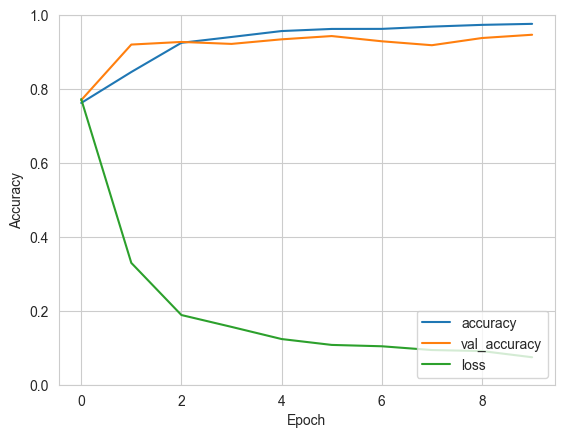

In [49]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
# show 10 random images from the validation set
val_images, val_labels = val_dataset.__getitem__(0)
val_predictions = d_model.predict(val_images)
val_predictions = np.round(val_predictions).flatten()

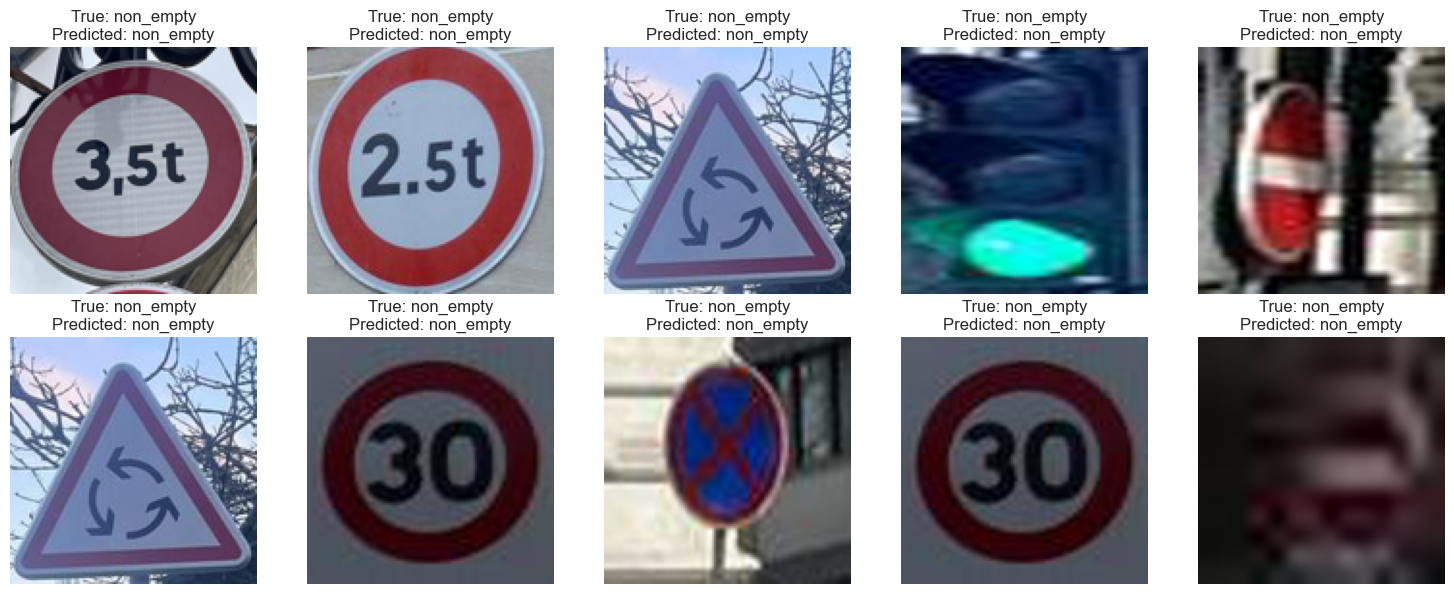

In [57]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(val_images))
    ax.imshow(val_images[idx])
    ax.set_title(f"True: {'non_empty' if val_labels[idx] == 1 else 'empty'}\nPredicted: {'non_empty' if val_predictions[idx] == 1 else 'empty'}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# PYRAMID DETECTION

In [85]:
def image_pyramid(image, scale=1.5, min_size=(48, 48)):
    pyramid = [image]
    while True:
        w = int(image.width / scale)
        h = int(image.height / scale)
        if w < min_size[0] or h < min_size[1]:
            break
        image = image.resize((w, h))
        pyramid.append(image)
    return pyramid

In [86]:
def sliding_window(image, step_size=32, window_size=(128, 128)):
    for y in range(0, image.height - window_size[1] + 1, step_size):
        for x in range(0, image.width - window_size[0] + 1, step_size):
            yield (x, y, image.crop((x, y, x + window_size[0], y + window_size[1])))

In [96]:
import numpy as np
import tensorflow as tf
from PIL import Image

# Load the models
discernment_model = tf.keras.models.load_model('discrimination_model.h5')
classification_model = tf.keras.models.load_model('model.h5')

def transform(image):
    image = image.resize((128, 128))
    image = np.array(image) / 255.0
    return image

def detect_and_classify(image_path, discernment_model, classification_model, label_encoder):
    image = Image.open(image_path).convert("RGB")
    pyramid = image_pyramid(image)

    detected_windows = []
    for scaled_image in pyramid:
        for (x, y, window) in sliding_window(scaled_image):
            window_array = transform(window)
            window_array = np.expand_dims(window_array, axis=0)
            pred = discernment_model.predict(window_array)
            if pred > 0.5:
                detected_windows.append((x, y, scaled_image, window))

    classifications = []
    print(f"Detected {len(detected_windows)} windows")
    for (x, y, scaled_image, window) in detected_windows:
        window_array = transform(window)
        window_array = np.expand_dims(window_array, axis=0)
        class_pred = classification_model.predict(window_array)
        class_label = label_encoder.classes_[np.argmax(class_pred)]
        classifications.append((x, y, scaled_image, class_label))

    return classifications

# Example usage
image_path = 'val/images/0149.jpg'
classifications = detect_and_classify(image_path, discernment_model, classification_model, label_encoder_class)

# Visualize the results
for (x, y, scaled_image, class_label) in classifications:
    print(f"Detected {class_label} at ({x}, {y}) in scaled image size {scaled_image.size}")

1/1 [==============================] - 0s 16ms/step
Detected 100 windows
1/1 [==============================] - 0s 16ms/step
Detected obligation at (480, 0) in scaled image size (750, 1000)
Detected obligation at (512, 0) in scaled image size (750, 1000)
Detected obligation at (544, 0) in scaled image size (750, 1000)
Detected obligation at (576, 0) in scaled image size (750, 1000)
Detected obligation at (608, 0) in scaled image size (750, 1000)
Detected obligation at (608, 32) in scaled image size (750, 1000)
Detected obligation at (256, 64) in scaled image size (750, 1000)
Detected obligation at (288, 64) in scaled image size (750, 1000)
Detected obligation at (224, 96) in scaled image size (750, 1000)
Detected obligation at (256, 96) in scaled image size (750, 1000)
Detected obligation at (288, 96) in scaled image size (750, 1000)
Detected obligation at (320, 96) in scaled image size (750, 1000)
Detected obligation at (320, 128) in scaled image size (750, 1000)
Detected obligation a

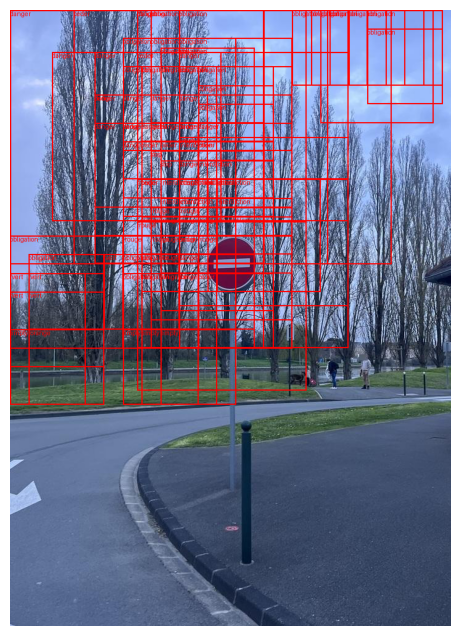

In [141]:
import matplotlib.pyplot as plt

def visualize_detections(image_path, classifications):
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    for (x, y, scaled_image, class_label) in classifications:
        scale = image.width / scaled_image.width
        x1 = int(x * scale)
        y1 = int(y * scale)
        x2 = x1 + int(128 * scale)
        y2 = y1 + int(128 * scale)
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1), class_label, fill="red")

    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example usage
visualize_detections(image_path, classifications)

In [7]:
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw
from tensorflow.keras.models import load_model

# Load the models
discernment_model = tf.keras.models.load_model('discrimination_model.h5')
classification_model = tf.keras.models.load_model('model.h5')

def transform(image):
    image = image.resize((128, 128))
    image = np.array(image) / 255.0
    return image

def image_pyramid(image, scale=1.5, min_size=(128, 128)):
    pyramid = [image]
    while True:
        w = int(image.width / scale)
        h = int(image.height / scale)
        if w < min_size[0] or h < min_size[1]:
            break
        image = image.resize((w, h))
        pyramid.append(image)
    return pyramid

def sliding_window(image, step_size=32, window_size=(128, 128)):
    for y in range(0, image.height - window_size[1] + 1, step_size):
        for x in range(0, image.width - window_size[0] + 1, step_size):
            yield (x, y, image.crop((x, y, x + window_size[0], y + window_size[1])))

def iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1b, y1b, x2b, y2b = box2
    xi1 = max(x1, x1b)
    yi1 = max(y1, y1b)
    xi2 = min(x2, x2b)
    yi2 = min(y2, y2b)
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2b - x1b) * (y2b - y1b)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area

def non_max_suppression(boxes, scores, iou_threshold=0.2):
    indices = np.argsort(scores)[::-1]
    keep = []
    while len(indices) > 0:
        current = indices[0]
        keep.append(current)
        if len(indices) == 1:
            break
        current_box = boxes[current]
        other_boxes = np.array(boxes)[indices[1:]]
        ious = np.array([iou(current_box, box) for box in other_boxes])
        indices = indices[1:][ious <= iou_threshold]
    return keep

def detect_and_classify(image_path, discernment_model, classification_model, label_encoder, iou_threshold=0.2):
    image = Image.open(image_path).convert("RGB")
    pyramid = image_pyramid(image)

    detected_windows = []
    for scaled_image in pyramid:
        for (x, y, window) in sliding_window(scaled_image):
            window_array = transform(window)
            window_array = np.expand_dims(window_array, axis=0)
            pred = discernment_model.predict(window_array)
            if pred >= 0.99:
                detected_windows.append((x, y, window, scaled_image))

    if not detected_windows:
        return []

    boxes = []
    scores = []
    for (x, y, window, scaled_image) in detected_windows:
        scale = image.width / scaled_image.width
        x1 = int(x * scale)
        y1 = int(y * scale)
        x2 = x1 + int(128 * scale)
        y2 = y1 + int(128 * scale)
        window_array = transform(window)
        window_array = np.expand_dims(window_array, axis=0)
        class_pred = classification_model.predict(window_array)
        score = max(class_pred[0])
        if score < 0.99:
            continue
        boxes.append((x1, y1, x2, y2))
        scores.append(score)

    keep_indices = non_max_suppression(boxes, scores, iou_threshold)
    final_boxes = [boxes[i] for i in keep_indices]
    final_scores = [scores[i] for i in keep_indices]
    final_labels = [np.argmax(classification_model.predict(np.expand_dims(transform(detected_windows[i][2]), axis=0))) for i in keep_indices]

    return final_boxes, final_scores, final_labels

In [10]:
# Example usage
image_path = 'val/images/0004.jpg'
try:
    final_boxes, final_scores, final_labels = detect_and_classify(image_path, discernment_model, classification_model, label_encoder_class, 0.2)
except Exception as e:
    print(f"Nothing to detect: {e}")

1/1 [==============================] - 0s 16ms/step


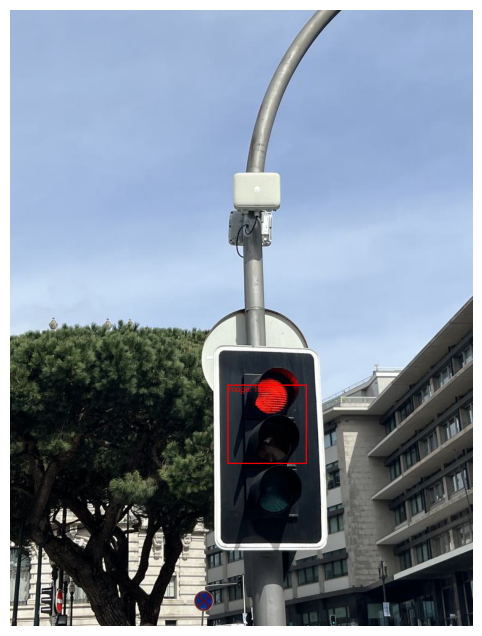

In [11]:
# Visualize the results
image = Image.open(image_path).convert("RGB")
draw = ImageDraw.Draw(image)

for (box, score, label) in zip(final_boxes, final_scores, final_labels):
    x1, y1, x2, y2 = box
    draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
    draw.text((x1, y1), f"{label_encoder_class.classes_[label]}: {score:.2f}", fill="red", font_size=12)

plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

In [139]:
test_images = os.listdir('test/')

results = []
# numéro-image,box1,box2,box3,box4,score,label

for i, img_name in enumerate(test_images):
    print(f"Processing image {i + 1}/{len(test_images)}")
    image_path = os.path.join('test', img_name)
    try:
        final_boxes, final_scores, final_labels = detect_and_classify(image_path, discernment_model, classification_model, label_encoder_class, 0.2)
    except Exception as e:
        print(f"Nothing to detect: {e}")
        continue

    if not final_boxes:
        continue

    for box, score, label in zip(final_boxes, final_scores, final_labels):
        x1, y1, x2, y2 = box
        results.append([img_name, x1, y1, x2, y2, score, label_encoder_class.classes_[label]])

results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', header=False, index=False)

Processing image 1/89
1/1 [==============================] - 0s 48ms/step
Processing image 2/89
1/1 [==============================] - 0s 16ms/step
Processing image 3/89
1/1 [==============================] - 0s 14ms/step
Processing image 4/89
1/1 [==============================] - 0s 14ms/step
Processing image 5/89
1/1 [==============================] - 0s 17ms/step
Processing image 6/89
1/1 [==============================] - 0s 13ms/step
Processing image 7/89
1/1 [==============================] - 0s 14ms/step
Processing image 8/89
1/1 [==============================] - 0s 14ms/step
Processing image 9/89
1/1 [==============================] - 0s 14ms/step
Processing image 10/89
1/1 [==============================] - 0s 15ms/step
Processing image 11/89
1/1 [==============================] - 0s 14ms/step
Processing image 12/89
1/1 [==============================] - 0s 17ms/step
Processing image 13/89
1/1 [==============================] - 0s 15ms/step
Processing image 14/89
1/1 [======

In [140]:
# load results.csv
# remove all of the .jpg at the end of the image names
# sort the dataframe by the image name
# save the df to results.csv

results_df = pd.read_csv('results.csv', header=None)
results_df[0] = results_df[0].apply(lambda x: x.replace('.jpg', ''))
results_df = results_df.sort_values(by=0)
results_df.to_csv('results.csv', header=False, index=False)